In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

2023-10-31 21:51:44.032091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4600, 224, 224, 3)
y_train shape: (4600,)
X_valid shape: (1152, 224, 224, 3)
y_valid shape: (1152,)
X_test shape: (1440, 224, 224, 3)
y_test shape: (1440,)


In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [9]:
# Initialize VGG16 with pre-trained weights (you can include or exclude top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# You can print a summary of the model's architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_valid, y_valid_onehot), 
                    batch_size=32, 
                    epochs=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                401424    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 15,116,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
144/144 [======================

In [10]:
model.save('../models/coral_vgg16.h5')

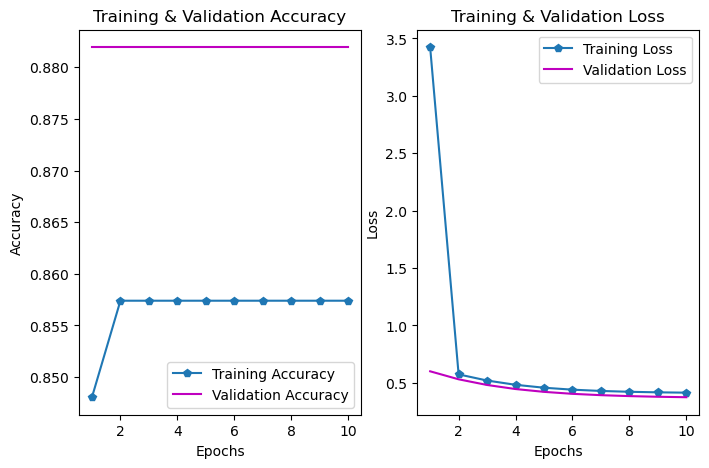

In [11]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [12]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy}")

45/45 [==============================] - 185s 4s/step - loss: 0.3460 - accuracy: 0.9000
Test Accuracy: 0.8999999761581421


In [16]:
# Load the saved model
model = load_model('../models/coral_vgg16.h5')

In [17]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(report)


45/45 [==============================] - 193s 4s/step - loss: 0.3460 - accuracy: 0.9000
Accuracy of the model is: 89.99999761581421 %
45/45 [==============================] - 199s 4s/step
Cohen's Kappa: 0.0
Classification Report:
                precision    recall  f1-score   support

          apal       0.00      0.00      0.00       144
pseudodiploria       0.90      1.00      0.95      1296

      accuracy                           0.90      1440
     macro avg       0.45      0.50      0.47      1440
  weighted avg       0.81      0.90      0.85      1440



/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

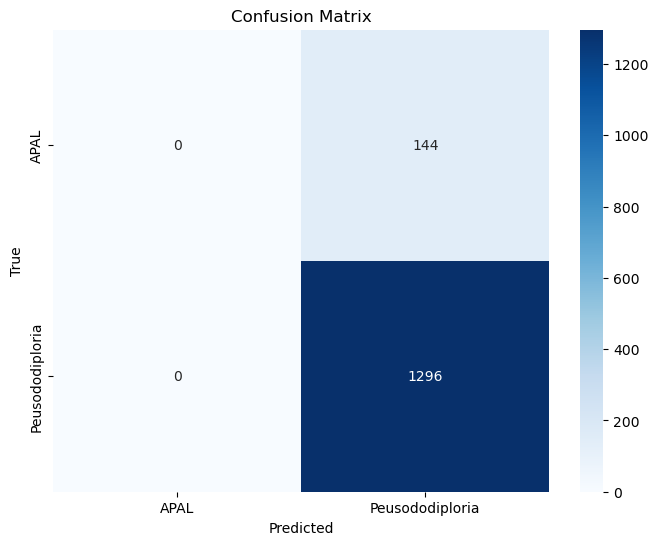

In [18]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Modeling with balanced data

In [17]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_bl_v2.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7592, 224, 224, 3)
y_train shape: (7592,)
X_valid shape: (1904, 224, 224, 3)
y_valid shape: (1904,)
X_test shape: (2376, 224, 224, 3)
y_test shape: (2376,)


In [18]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels in both training and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert the encoded labels to one-hot encoded format
num_classes = len(label_encoder.classes_)
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid_encoded, num_classes=num_classes)

In [19]:
# Initialize VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top of the VGG16 base
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Freeze the layers of the VGG16 base model up to a certain point
for layer in base_model.layers[:5]:
    layer.trainable = False

# Add your custom classification layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Adding L2 regularization
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjusted learning rate
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint to save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Print a summary of the model's architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_valid, y_valid_onehot), 
                    batch_size=32, 
                    epochs=5,  # You can increase the number of epochs
                    callbacks=[early_stopping, model_checkpoint])  # Applying early stopping


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 64)                1605696   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,320,514
Trainable params: 16,207,938
Non-trainable params: 112,576
_________________________________________________________________
Epoch 1/5
  7/238 [.................

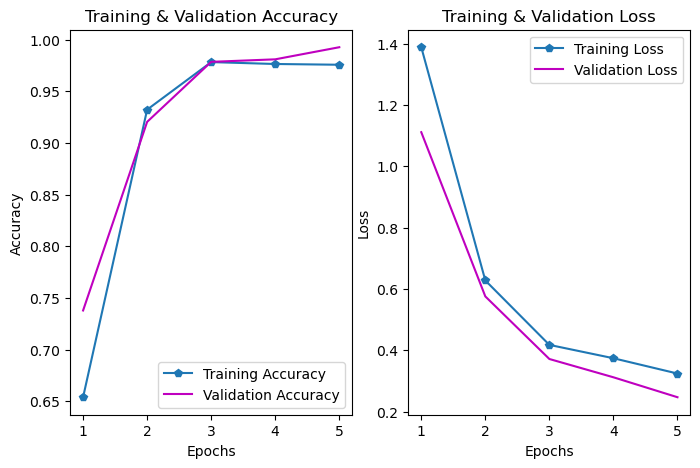

In [13]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [14]:
model.save('../models/coral_vgg16_bl.h5')

In [17]:
# Load the model
model = load_model('../models/coral_vgg16_bl.h5')

In [19]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# You can also calculate other evaluation metrics, such as precision, recall, and F1-score.
from sklearn.metrics import classification_report

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

cohen_kappa = cohen_kappa_score(y_test_class, y_pred_class)

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Cohen's Kappa:", cohen_kappa)
print("Classification Report:")
print(report)


81/81 [==============================] - 338s 4s/step - loss: 0.2514 - accuracy: 0.9930
Accuracy of the model(Two layers) is: 99.29906725883484 %
81/81 [==============================] - 339s 4s/step
Cohen's Kappa(Two layers): 0.985947555049687
Classification Report(Two layers):
                precision    recall  f1-score   support

          APAL       0.99      1.00      0.99      1344
Pseudodiploria       1.00      0.99      0.99      1224

      accuracy                           0.99      2568
     macro avg       0.99      0.99      0.99      2568
  weighted avg       0.99      0.99      0.99      2568



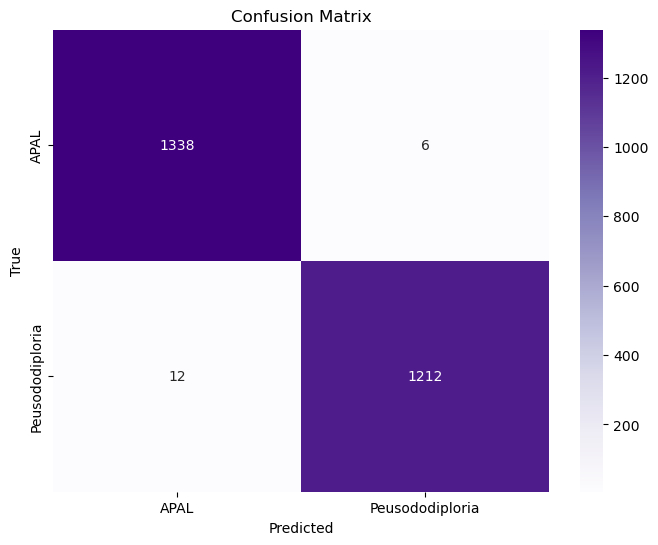

In [20]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## No freezing for balanced

In [4]:
# Initialize VGG16 with pre-trained weights (you can include or exclude top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

# You can print a summary of the model's architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, 
                    validation_data=(X_valid, y_valid_onehot), 
                    batch_size=32, 
                    epochs=10)


2023-10-31 21:53:06.938034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 16)                401424    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 15,116,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
256/256 [========================

In [6]:
model.save('../models/coral_vgg16_bl_v2.h5')

In [ ]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

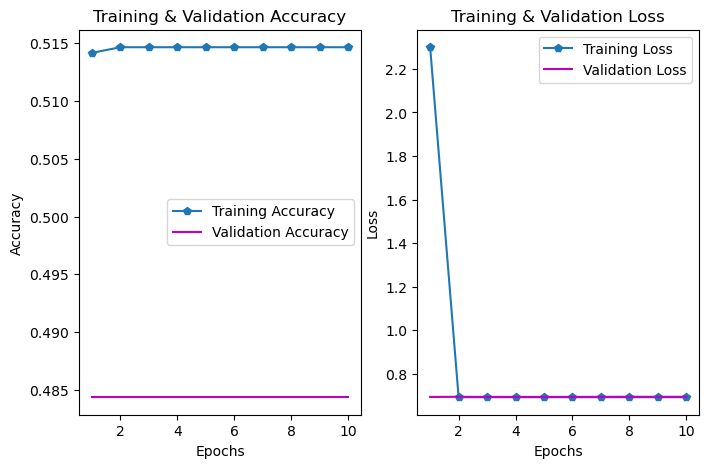

In [7]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [14]:
# Load the model
model = load_model('../models/coral_vgg16_bl_v2.h5')

In [15]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)


81/81 [==============================] - 337s 4s/step - loss: 0.6921 - accuracy: 0.5234
Accuracy of the model is: 52.336448431015015 %
81/81 [==============================] - 338s 4s/step
Classification Report:
                precision    recall  f1-score   support

          APAL       0.52      1.00      0.69      1344
Pseudodiploria       0.00      0.00      0.00      1224

      accuracy                           0.52      2568
     macro avg       0.26      0.50      0.34      2568
  weighted avg       0.27      0.52      0.36      2568



/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

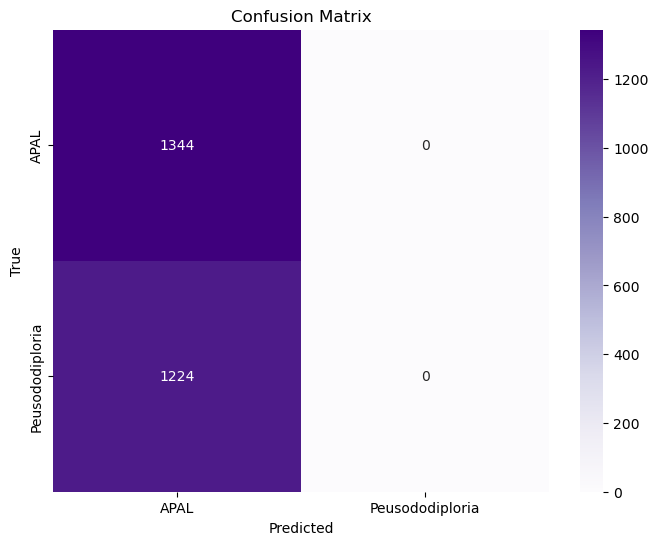

In [16]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Freezing all layer

In [8]:

# Define the model
pre_trained_model = VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

#freeze the base model
base_model.trainable = False

#Create new model on top
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2048,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.35))
model.add(Dense(2,activation='softmax',kernel_initializer='glorot_normal'))

model.summary()

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using your data
history = model.fit(
    X_train,  
    y_train_onehot,  
    epochs=10,
    validation_data=(X_valid, y_valid_onehot),
    workers=10,
    use_multiprocessing=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              51382272  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [9]:
model.save('../models/coral_vgg16_bl_v3.h5')

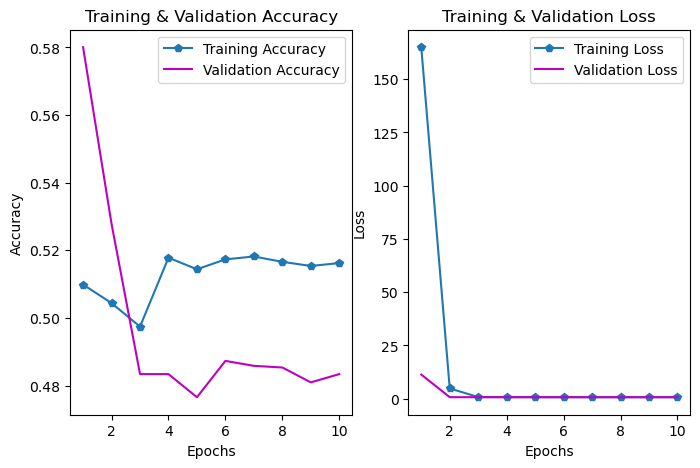

In [10]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [11]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)


81/81 [==============================] - 337s 4s/step - loss: 0.6932 - accuracy: 0.5280
Accuracy of the model is: 52.80373692512512 %
81/81 [==============================] - 334s 4s/step
Classification Report:
                precision    recall  f1-score   support

          APAL       0.53      0.99      0.69      1344
Pseudodiploria       0.67      0.02      0.04      1224

      accuracy                           0.53      2568
     macro avg       0.60      0.51      0.36      2568
  weighted avg       0.59      0.53      0.38      2568



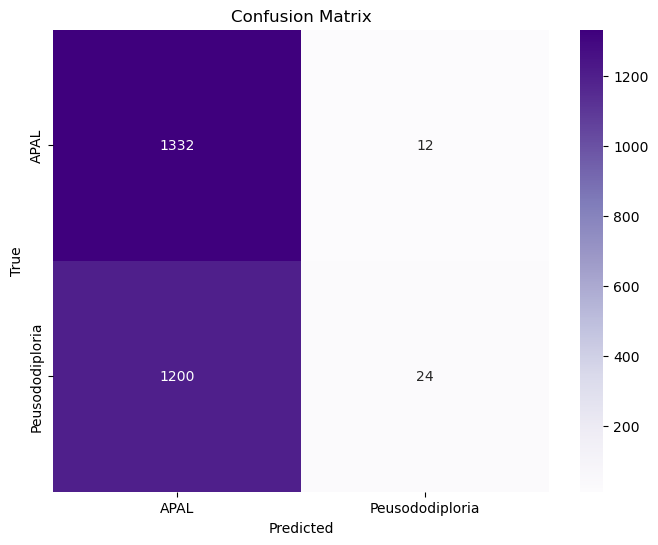

In [12]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fine tuning

In [13]:
base_model=model.layers[0]
#Un-Freezing last 2 blocks(i.e. block4 and 5)

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
base_model.summary()
model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model using your data
history = model.fit(
    X_train,  
    y_train_onehot,  
    epochs=10,
    validation_data=(X_valid, y_valid_onehot),
    workers=10,
    use_multiprocessing=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

KeyboardInterrupt: 

In [ ]:
model.save('../models/coral_vgg16_bl_v4.h5')

In [ ]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
# Evaluate the model on the test data
accuracy = model.evaluate(X_test, y_test_onehot)[1]  # Index 1 corresponds to accuracy
print("Accuracy of the model is:", accuracy * 100, "%")

# Get model predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded labels back to class labels
y_test_class = label_encoder.inverse_transform(np.argmax(y_test_onehot, axis=1))
y_pred_class = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Generate a classification report
report = classification_report(y_test_class, y_pred_class)

print("Classification Report:")
print(report)


In [ ]:
# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()